In [1]:
import numpy as np
print('NumPy version {}'.format(np.__version__))
import tensorflow as tf
print('Tensorflow version {}'.format(tf.__version__))

NumPy version 1.21.6
Tensorflow version 2.8.0


In [2]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,LSTM,Dropout,GRU
from tensorflow.python.keras import optimizers
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

             Open   High    Low  Close    Volume Name
Date                                                 
2006-01-03  39.83  40.36  39.30  40.19  12839400  JPM
2006-01-04  39.78  40.14  39.42  39.62  13491800  JPM
2006-01-05  39.61  39.81  39.50  39.74   8109400  JPM
2006-01-06  39.92  40.24  39.55  40.02   7966900  JPM
2006-01-09  39.88  40.72  39.88  40.67  16575200  JPM
2006-01-10  40.50  40.75  40.07  40.73  16614900  JPM
2006-01-11  40.73  40.87  40.61  40.70  12333100  JPM
2006-01-12  40.25  40.42  39.90  39.95  12230400  JPM
2006-01-13  39.78  40.03  39.65  39.92  10961200  JPM
2006-01-17  39.48  39.82  39.41  39.71   9941400  JPM


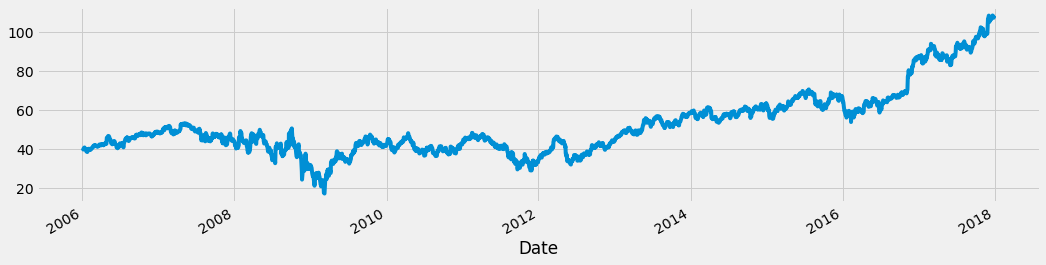

In [26]:
# Error
def error(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return

# Test vs. predicted graph
def plot_test_vs_pred(test,predicted):
    plt.rcParams["figure.figsize"] = (40,30)
    plt.plot(test,color='red',label='Stock Price')
    plt.plot(predicted,color='blue',label='Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    return

# Load data
def load_data(name:str):
    df = pd.read_csv(name+'_2006-01-01_to_2018-01-01.csv',index_col='Date',parse_dates=['Date'])
    print(df.head(10))
    # Visualization as we read it
    plt.rcParams["figure.figsize"] = (16,4)
    df.High.plot()
    plt.show()
    return df

df = load_data('JPM')

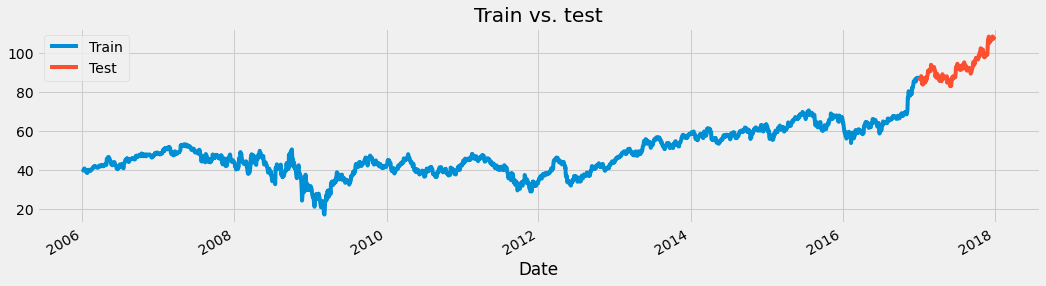

In [73]:
def train_test(feature,year):
    train = df[feature][:str(year)].values.reshape(-1,1)
    test = df[feature][str(year+1):].values.reshape(-1,1)
    return train,test

def plot_train_test(feature,year):
    df[feature][:str(year)].plot(figsize=(16,4),legend=True)
    df[feature][str(year+1):].plot(figsize=(16,4),legend=True)
    plt.legend(['Train','Test'])
    plt.title('Train vs. test')
    plt.show()
    return

train,test = train_test('High',2016)
plot_train_test('High',2016)

In [74]:
def scaler(mi,ma):
    sc = MinMaxScaler(feature_range=(mi,ma))
    train_scaled = sc.fit_transform(train)
    return sc,train_scaled

sc,train_scaled = scaler(0,1)

def train_Xy(train_scaled,days):
    X_train,y_train = [],[]
    for i in range(days,len(train_scaled)):
        X_train.append(train_scaled[i-days:i,0])
        y_train.append(train_scaled[i,0])
    X_train,y_train = np.array(X_train),np.array(y_train)
    return np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1)),y_train

X_train,y_train = train_Xy(train_scaled,60)

In [29]:
print(X_train.shape)
print(y_train.shape)

(2709, 60, 1)
(2709,)


In [66]:
def my_model(X_train,y_train,epochs):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    model.fit(X_train,y_train,epochs=epochs,batch_size=32)
    return model

model = my_model(X_train,y_train,20)

Epoch 1/20
85/85 [==============================] - 16s 109ms/step - loss: 0.0156
Epoch 2/20
85/85 [==============================] - 9s 109ms/step - loss: 0.0076
Epoch 3/20
85/85 [==============================] - 9s 109ms/step - loss: 0.0059
Epoch 4/20
85/85 [==============================] - 10s 119ms/step - loss: 0.0050
Epoch 5/20
85/85 [==============================] - 10s 115ms/step - loss: 0.0041
Epoch 6/20
85/85 [==============================] - 10s 113ms/step - loss: 0.0036
Epoch 7/20
85/85 [==============================] - 10s 113ms/step - loss: 0.0033
Epoch 8/20
85/85 [==============================] - 9s 111ms/step - loss: 0.0030
Epoch 9/20
85/85 [==============================] - 9s 109ms/step - loss: 0.0027
Epoch 10/20
85/85 [==============================] - 9s 109ms/step - loss: 0.0024
Epoch 11/20
85/85 [==============================] - 9s 110ms/step - loss: 0.0023
Epoch 12/20
85/85 [==============================] - 9s 109ms/step - loss: 0.0021
Epoch 13/20
85/85 [=

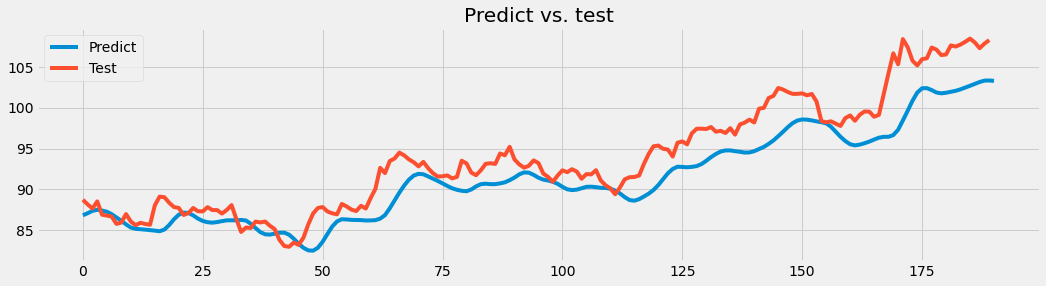

In [80]:
def test_Xy(test,days):
    X_test = []
    test_scaled = sc.transform(test)
    for i in range(days,len(test)):
        X_test.append(test_scaled[i-days:i,0])
    X_test = np.array(X_test)
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

days = 60
X_test = test_Xy(test,days)
y_test = test.reshape(-1,1)[days+1:]
y_pred = sc.inverse_transform(model.predict(X_test).reshape(-1,1))

def plot_pred_vs_test(pred,test):
    plt.rcParams["figure.figsize"] = (16,4)
    plt.plot(pred)
    plt.plot(test)
    plt.legend(['Predict','Test'])
    plt.title('Predict vs. test')
    plt.show()
    return

plot_pred_vs_test(y_pred,y_test)

# Define Class

In [125]:
class LSTM_model:
    
    import numpy as np
    import tensorflow as tf
    from tensorflow.python.keras.models import Sequential
    from tensorflow.python.keras.layers import Dense,LSTM,Dropout,GRU
    from tensorflow.python.keras import optimizers
    import math
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import MinMaxScaler
    import matplotlib.pyplot as plt
    plt.style.use('fivethirtyeight')
    import pandas as pd
    
    def __init__(self,path,days):
        self.df = pd.read_csv(path,index_col='Date',parse_dates=['Date'])
        self.days = days
        print(self.df.head(10))
    
    def version_info(self):
        print('Tensorflow version {}'.format(tf.__version__))
        print('NumPy version {}'.format(np.__version__))
        return 
    
    # Error
    def error(self,test,predicted):
        self.rmse = math.sqrt(mean_squared_error(self.test, self.predicted))
        print("The root mean squared error is {}.".format(self.rmse))
        return self.rmse
    
    # Test vs. predicted graph
    def plot_test_vs_pred(self,test,predicted):
        plt.rcParams["figure.figsize"] = (40,30)
        plt.plot(test,color='red',label='Stock Price')
        plt.plot(predicted,color='blue',label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        return

    # Load data
    def plot_data(self,name:str):
        # Visualization as we read it
        plt.rcParams["figure.figsize"] = (16,4)
        self.df[name].plot()
        plt.show()
        return
    
    def train_test(self,feature,year):
        self.train = self.df[feature][:str(year)].values.reshape(-1,1)
        self.test = self.df[feature][str(year+1):].values.reshape(-1,1)
        self.feature,self.year = feature,year   
        return self.train,self.test

    def plot_train_test(self):
        self.df[self.feature][:str(self.year)].plot(figsize=(16,4),legend=True)
        self.df[self.feature][str(self.year+1):].plot(figsize=(16,4),legend=True)
        plt.legend(['Train','Test'])
        plt.title('Train vs. test')
        plt.show()
        return
    
    def scaler(self,mi,ma):
        self.sc = MinMaxScaler(feature_range=(mi,ma))
        self.train_scaled = self.sc.fit_transform(train)
        return self.sc,self.train_scaled
    
    # Crucial steps
    def train_Xy(self):
        self.X_train,self.y_train = [],[]
        for i in range(self.days,len(self.train_scaled)):
            self.X_train.append(self.train_scaled[i-self.days:i,0])
            self.y_train.append(self.train_scaled[i,0])
        self.X_train,self.y_train = np.array(self.X_train),np.array(self.y_train)
        self.X_train = np.reshape(self.X_train, (self.X_train.shape[0],self.X_train.shape[1],1))
        #return self.X_train,self.y_train
    
    def lstm(self,epochs):
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(self.X_train.shape[1],1)))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(units=50, return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(units=50, return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(units=50))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=1))
        self.model.compile(optimizer='rmsprop',loss='mean_squared_error')
        self.model.fit(self.X_train,self.y_train,epochs=epochs,batch_size=32)
        #return self.model
    
    def test_Xy(self):
        self.X_test = []
        self.test_scaled = self.sc.transform(self.test)
        for i in range(self.days,len(self.test)):
            self.X_test.append(self.test_scaled[i-self.days:i,0])
        self.X_test = np.array(self.X_test)
        self.X_test = np.reshape(self.X_test,(self.X_test.shape[0],self.X_test.shape[1],1)) 
        #return self.X_test
    
    def plot_pred_vs_test(self):
        self.pred = self.sc.inverse_transform(self.model.predict(self.X_test).reshape(-1,1))
        plt.rcParams["figure.figsize"] = (16,4)
        plt.plot(self.pred)
        plt.plot(self.test[self.days+1:])
        plt.legend(['Predict','Test'])
        plt.title('Predict vs. test')
        plt.show()
        return

In [126]:
myclass = LSTM_model('JPM_2006-01-01_to_2018-01-01.csv',60)

             Open   High    Low  Close    Volume Name
Date                                                 
2006-01-03  39.83  40.36  39.30  40.19  12839400  JPM
2006-01-04  39.78  40.14  39.42  39.62  13491800  JPM
2006-01-05  39.61  39.81  39.50  39.74   8109400  JPM
2006-01-06  39.92  40.24  39.55  40.02   7966900  JPM
2006-01-09  39.88  40.72  39.88  40.67  16575200  JPM
2006-01-10  40.50  40.75  40.07  40.73  16614900  JPM
2006-01-11  40.73  40.87  40.61  40.70  12333100  JPM
2006-01-12  40.25  40.42  39.90  39.95  12230400  JPM
2006-01-13  39.78  40.03  39.65  39.92  10961200  JPM
2006-01-17  39.48  39.82  39.41  39.71   9941400  JPM


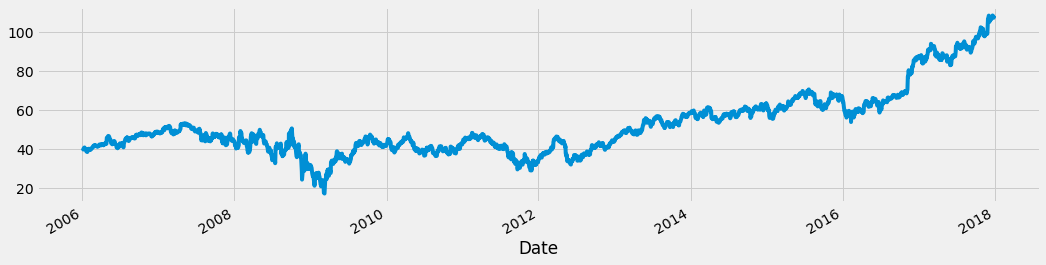

In [127]:
myclass.plot_data('High')

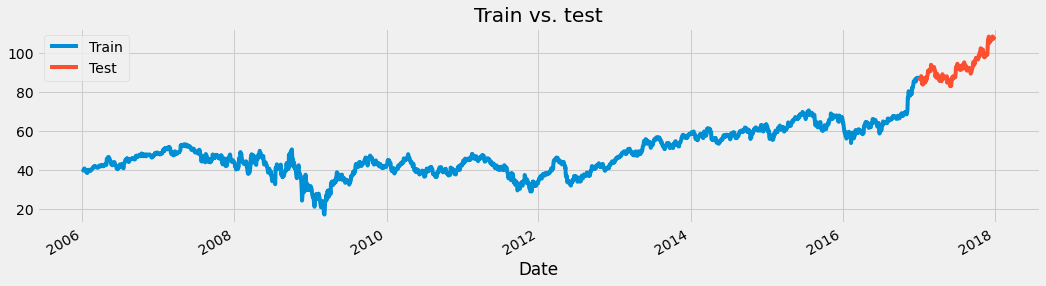

In [128]:
myclass.train_test('High',2016)
myclass.plot_train_test()

In [129]:
myclass.scaler(0,1)
myclass.train_Xy()

In [130]:
myclass.lstm(30)

Epoch 1/30
85/85 [==============================] - 16s 113ms/step - loss: 0.0162
Epoch 2/30
85/85 [==============================] - 9s 112ms/step - loss: 0.0074
Epoch 3/30
85/85 [==============================] - 9s 109ms/step - loss: 0.0059
Epoch 4/30
85/85 [==============================] - 9s 110ms/step - loss: 0.0051
Epoch 5/30
85/85 [==============================] - 10s 117ms/step - loss: 0.0041
Epoch 6/30
85/85 [==============================] - 10s 117ms/step - loss: 0.0039
Epoch 7/30
85/85 [==============================] - 9s 111ms/step - loss: 0.0032
Epoch 8/30
85/85 [==============================] - 9s 109ms/step - loss: 0.0030
Epoch 9/30
85/85 [==============================] - 10s 114ms/step - loss: 0.0027
Epoch 10/30
85/85 [==============================] - 10s 113ms/step - loss: 0.0024
Epoch 11/30
85/85 [==============================] - 9s 110ms/step - loss: 0.0024
Epoch 12/30
85/85 [==============================] - 10s 123ms/step - loss: 0.0021
Epoch 13/30
85/85 [

In [131]:
myclass.test_Xy()

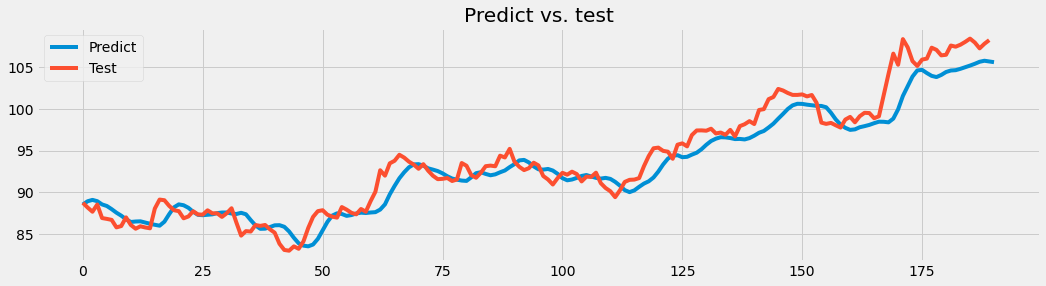

In [132]:
myclass.plot_pred_vs_test()